## ResNet50 Architecture on Covid X-Ray transfer learning from Pnumothorax X-Ray and imagenet.

* Authored by Doug Johnson  

Some code borrowed from Machine Learning Mastery and other websites. 

### Summary:  
Use imagenet weights and apply transfer learning.  
Ran on Colab, referenced premade tensors in shared folder as inputs.  
Output weights and model in a single file.  
Load best weights after epochs into model after compile, reran.

Goal get loss down, lr decreasing may be issue. May wish to gridsearch on optimizers.  

### Change Log Details
V2.0  
* Use Covid tensors to train and test on
* Create VERSION GLOBAL VAR for output weight and model files, update each time
* Load weights from V1.2 run
* Using optimizer = Adam

V1.2   
* Added ReduceLRonPlateau and Callback  
* Using Adadelta  
* Trained initial model and loading weights via model.load_weights(WEIGHTS_ONLY_BEST)  
* ImageDataGenerator added zoom, crop, rotate ...   

V1.1    
* Only ResNet50  
* Clean up and notate    
* Document steps, understand process prior to moving on.     

V1.0   
* Adapt Cats vs Dogs in local environment to X-Ray tensors on Google Drive   
* Get familiar with Colab access to images in shared folder, GPU, and high RAM mode.   
* Get a functioning baseline model  
* Use .npy tensor    
* Move to more current model, ResNet50    
* Train test with imagenet weights on pneoumothorax export weights model combo.   



### Next Steps:  
*  Convert X_train and y_train to pd.dataframe from np.array, explore  
*  Load model weight combo for prediction new   
*  GridSearch     
*  Use GitHub as source code repo for notebooks       
*  Multi-class classification  ?      
*  Research medical pre-trained imagenet ... Stanford, 1000 lung  

### General: 
* Review performance stats and charts, accuracy vs val accuracy 
   LR in background, want low val_loss (.3) and loss (.5) accuracy val (.7-.8)     
* Images being standardized prior to .npy tensor, process , yes, Jie  dividing by 255 like in a prior notbook.    
* Debug API Anatoly, why not working, what issue?      
* Understand tensor .npy creation process, document   
* In test harness, train_datagen.flow and train_datagen.flow_from_directory have different inputs   
* steps_per_epoch = DATASET_SIZE//BATCH_SIZE  how know this, how relate to .npy tensor?  
* Debug Anatoly/Jie the programming of functions for commoditizing the model architecture.  

  

## Import Modules

In [2]:
import sys
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input

from keras.optimizers import SGD, Adam
#from preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# LOAD DATASET
from os import listdir
import numpy as np
from numpy import asarray, save

# PLOT IMAGES 
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

Using TensorFlow backend.


## Global Variable Designation

In [0]:
VERSION_IN        = 'V1-2_Adam' # Adam is optimizer 
VERSION_OUT       = 'V2-0'
DATASET_PATH      = 'images/Preprocessed_Tensors/COVID_img_preprocessed/'
BASE_PATH         = '/content/drive/My Drive/'
WEIGHTS_IN        = BASE_PATH + 'ResNet50_weights_best_' + VERSION_IN + '.hdf5' 
WEIGHTS_MODEL_IN  = BASE_PATH + 'ResNet50_model_weights_final_' + VERSION_IN + '.h5' 
WEIGHTS_MODEL_F   = BASE_PATH + 'ResNet50_model_weights_final_' + VERSION_OUT + '.h5' # IDEALLY INPUT RESNET AND MODEL/OUTPUT FILE CALLED
WEIGHTS_ONLY_BEST = BASE_PATH + 'ResNet50_weights_best_' + VERSION_OUT + '.hdf5'
FOLDER_PATH_TRAIN = BASE_PATH + DATASET_PATH
FOLDER_PATH_TEST  = BASE_PATH + DATASET_PATH
IMAGE_SIZE        = 224   
INPUT_LAYERS      = 3     # RED, GREEN, BLUE = 3; IF 3 REMOVE FROM ImageDataGenerator
LAYERS_TRANS      = 3     # GREYSCALE = 1; FOR MEMORY AND RUNTIME EFFICIENCY CONVERT TO GREYSCALE, !!! DO SOME REQUIRE 1 VS 3?
NUM_CLASSES       = 2     # NUMBER OF TARGET CLASSES, BINARY - TRUE OR FALSE = 2,CAT OR DOG OR CHICKEN = 3 ...
BATCH_SIZE_N      = 16    # MEMORY MANAGEMENT, INCREASE IF HAVE LOT OF MEMORY
FREEZE_LAYERS     = 2     # !!! READ UP ON SIGNIFICANCE
NUM_EPOCHS        = 50  
VERBOSE_EPOCH     = 1     # EPOCH OUTPUT 0 = NO OUTPUT, 1 = OUTPUT

## Access Data

In [4]:
# MOUNT GOOGLE DRIVE TO ACCESS SHARED IMAGES FOLDER
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
ls /content/drive/My\ Drive/images/Preprocessed_Tensors/

COVID_img_preprocessed/  pnumothorax_preprocessed/


In [6]:
# ls /content/drive/My Drive/images/NIH chest X ray images/images_001/images/
ls /content/drive/My\ Drive/images/Preprocessed_Tensors/COVID_img_preprocessed/

X_test.npy  X_train.npy  y_test.npy  y_train.npy


In [0]:
# TENSORS 
X_train = np.load(FOLDER_PATH_TRAIN + 'X_train.npy')
X_test  = np.load(FOLDER_PATH_TEST  + 'X_test.npy')
y_train = np.load(FOLDER_PATH_TRAIN + 'y_train.npy')
y_test  = np.load(FOLDER_PATH_TEST  + 'y_test.npy')

In [8]:
print("Shape of tensors:")
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("X_test:  {}".format(X_test.shape))
print("y_test:  {}".format(y_test.shape))

Shape of tensors:
X_train: (1961, 224, 224, 3)
y_train: (1961,)
X_test:  (1000, 224, 224, 3)
y_test:  (1000,)


In [0]:
#ls /content/drive/My\ Drive/images/Preprocessed_Tensors/
#ls /content/drive/My\ Drive/images/NIH chest X ray images/

In [10]:
# CHANGE DIRECTORY TO IMAGES
cd /content/drive/My\ Drive/images/NIH chest X ray images/

/content/drive/.shortcut-targets-by-id/1iVV0f2kJC19GJZlSKvc9A6theRLdsc6-/COVID_19_project/NIH chest X ray images


## View Images

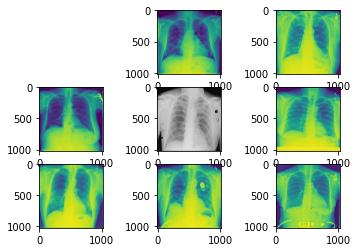

In [11]:
# VIEW SAMPLE OF IMAGES
# !!! CHANGE SO GET RANDOM SELECTION WITHIN FOLDER, INCREASE HEIGHT, WIDTH AND SPACING
folder = BASE_PATH + 'images/NIH chest X ray images/images_001/images/'
for i in range(1,9):
    plt.subplot(330 + 1 + i)
    filename =  folder + '0000000' + str(i) + '_000.png'
    image = imread(filename)
    plt.imshow(image)
plt.show()

## Define Model Architecture

In [0]:
def define_model_resnet50():
    '''
    ResNet50 model using imagenet weight file for transfer learning.
    Freeze layers. Trainable freeze layers, others, not
    Optimizer is using learning rate, better to use Adam or SGD and .00001 !!!
    '''
    # !!! GO TO KERAS DOCUMENTATION ONLINE AND LOOK AT PARAM
    net = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMAGE_SIZE, IMAGE_SIZE, INPUT_LAYERS))
    x = net.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
    net_final = Model(inputs=net.input, outputs=output_layer)
    for layer in net_final.layers[:FREEZE_LAYERS]:
        layer.trainable = False
    for layer in net_final.layers[FREEZE_LAYERS:]:
        layer.trainable = True
    #net_final.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    net_final.compile(optimizer=keras.optimizers.Adadelta(), 
                      loss='categorical_crossentropy', metrics=['accuracy'])
    # CHANGED TO momentum, TO DECREASE LEARNING AS EPOCHS PROGRESS
    #opt = SGD(lr=0.01, momentum=0.9)
    #net_final.compile(optimizer=opt, 
    #                  loss='categorical_crossentropy', metrics=['accuracy'])
    #print(net_final.summary())
    return net_final

## Define Learning Rate and Callback Checkpoint

In [0]:
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# IMPLEMENT LEARNING RATE REDUCTION BASED ON VALIDATION LOSS
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', #monitor val_loss
    factor=0.2, 
    patience=4, #If model does not improve by epsilon in 4 epochs, then reduce lr by factor.  
    min_delta=0.0001, 
    cooldown = 3, # wait 3 epochs before starting again
    min_lr=10e-5,
    #min_lr=0.0000001
    verbose=1)

# SAVE WEIGHT FILE FROM BEST RUN, HAVE VERBOSE OUTPUT BASED ON VALIDATION ACCURACY
checkpoint = keras.callbacks.callbacks.ModelCheckpoint(
    WEIGHTS_ONLY_BEST, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

## Plot Diagnostic Learning Curves

In [0]:
def summarize_diagnostics(history):
    '''
    Plot entropy chart
    Plot accuracy chart
    '''
    
    plt.figure(figsize=(8,10))

    # PLOT LOSS
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    # PLOT ACCURACY
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()
    plt.close()

## Define Test Harness

In [0]:
def run_test_harness():
    '''
    Test harness calls model definition function 
    Resizes images
    Creates more images with Image Data Generator: rotate, shift, shear, zoom, flip, ...
    Fits the data
    Gives performance summary
    Calls the learning curve graph
    '''
    
    model = define_model_resnet50()
    model.load_weights(WEIGHTS_IN)

    # TENSORS 
    X_train = np.load(FOLDER_PATH_TRAIN + 'X_train.npy')
    X_test  = np.load(FOLDER_PATH_TEST  + 'X_test.npy')
    y_train = np.load(FOLDER_PATH_TRAIN + 'y_train.npy')
    y_test  = np.load(FOLDER_PATH_TEST  + 'y_test.npy')
    
    # SPECIFIC REFERENCING imagenet IN BACKGROUND? DOES THIS ADD VALUE? !!!
    #train_datagen = ImageDataGenerator(featurewise_center=True)

    # CREATE DATA ITERATORS
    train_datagen = ImageDataGenerator(rotation_range=15, 
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range= 0.2,
                                      zoom_range=0.2,
                                      horizontal_flip = True)

    # SPECIFY imagenet MEAN VALUES FOR CENTERING
    train_datagen.mean = [123.68, 116.779, 103.939]

    # WORK WITH TENSORS
    train_batches = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE_N)
    test_batches = train_datagen.flow(X_test, y_test, batch_size = BATCH_SIZE_N)

    print("train batches {}".format(len(train_batches)))
    print("test  batches {}".format(len(test_batches)))
    print("\n")

#steps_per_epoch: Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting 
#the next epoch. It should typically be equal to ceil(num_samples / batch_size). Optional for Sequence: if unspecified, 
# will use the len(generator) as a number of steps.
# You can set it equal to num_samples // batch_size, which is a typical choice.
#However, steps_per_epoch give you the chance to "trick" the generator when updating the learning rate using 
#ReduceLROnPlateuau() callback, because this callback checks the drop of the loss once each epoch has finished. 
#If the loss has stagnated for a patience number of consecutive epochs, the callback decreases the learning rate to "slow-cook" the network. 
#If your dataset is huge, as it is usually the case when you need to use generators, you would probably like to
# decay the learning rate within a single epoch (since it includes a big number of data). This can be achieved by setting 
#steps_per_epoch to a value that is less than num_samples // batch_size without affecting the overall number of training epochs of your model.

    # FIT MODEL
    history = model.fit_generator(train_batches, 
                                  steps_per_epoch=len(train_batches),
                                  callbacks=[lr_reduce,checkpoint],
                                  validation_data=test_batches, 
                                  validation_steps=len(test_batches), 
                                  verbose=VERBOSE_EPOCH,
                                  epochs=NUM_EPOCHS)

    # SAVE TRAINED WEIGHTS
    model.save(WEIGHTS_MODEL_F)

    # EVALUATE MODEL
    _, acc = model.evaluate_generator(test_batches, 
                                      steps=len(test_batches), 
                                      verbose=0)
    
    print("\nAccuracy > {:.3f}".format(acc * 100.0))

    # LEARNING CURVES
    summarize_diagnostics(history)

## Run Test Harness

In [16]:
run_test_harness()

    8192/94653016 [..............................] - ETA: 1s

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
train batches 123
test  batches 63


Epoch 1/50


ValueError: ignored